In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import pickle

%matplotlib inline

In [2]:
wide_dist_pickle = pickle.load(open("./wide_dist_pickle.p", "rb" ))
dist = wide_dist_pickle['dist']
mtx = wide_dist_pickle['mtx']

### Defaults

In [3]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
plotit = False

#global variables for left and right fit, and curvature
global left_fit_g, right_fit_g, curvature_g
left_fit_g, right_fit_g, curvature_g = [], [], []

#vertices to mask and get region of interest
left_bottom = (100, 720)
right_bottom = (1260, 720)
apex1 = (610, 410)
apex2 = (680, 410)
inner_left_bottom = (310, 720)
inner_right_bottom = (1150, 720)
inner_apex1 = (700,480)
inner_apex2 = (650,480)
vertices = np.array([[left_bottom, apex1, apex2, right_bottom, inner_right_bottom, inner_apex1, inner_apex2, inner_left_bottom]], 
                    dtype=np.int32)

### Helper functions

In [4]:
def img_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

#Function to check if the grad is within a certain range of threshold
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=13, thresh=(50, 255)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/ac652b00-7257-4c90-8087-eda8f152a035
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#Function to check if the magnitude of gradient is within a certain threshold range
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=13, mag_thresh=(30, 100)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/78be8208-1af0-4cb4-8a60-2d904b696449
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
# def dir_threshold(img, sobel_kernel=13, thresh=(-np.pi, 1.33)):
def dir_threshold(img, sobel_kernel=13, thresh=(0, np.pi)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/d9ad4008-6744-4dc1-803d-e43a67cc050f
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, thresh=(120, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    s_mask = np.zeros_like(s_channel)
    s_mask[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1

    return s_mask

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def fit_poly(binary_warped):    
    '''
    Input - binary wrapped image 
    Returns - poly fit (second order polynomial to each, and left & right line pixel positions)
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[
                        0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + \
        right_fit[1] * ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[
        left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[
        right_lane_inds]] = [0, 0, 255]

    if plotit:
        plt.imshow(out_img / 255)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    fit_vals = (leftx, lefty, rightx, righty, ploty)
    return fit_vals, left_fit, right_fit

def smooth_fits(left_fit, right_fit, n=20):
    """
    Smoothes the polynomial fits
    Inputs:
    - left, right fit : Polynomial fit of current frame
    """
    left_fit_g.append(left_fit)
    right_fit_g.append(right_fit)

    left_fit_np = np.array(left_fit_g)
    right_fit_np = np.array(right_fit_g)

    if len(left_fit_g) > n:
        left_fit = np.mean(left_fit_np[-n:, :], axis=0)
    if len(right_fit_g) > n:
        right_fit = np.mean(right_fit_np[-n:, :], axis=0)
    return left_fit, right_fit

### Helper functions

In [6]:
def calc_curv(img, left_fit, right_fit, fits):
    """
    Calculates curvature for given polynomial
    Returns:
    - left_curverad, right_curverad : Radius of curvature in meters
    """
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = img.shape[0]
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fits[1] * ym_per_pix, fits[0] * xm_per_pix, 2)
    right_fit_cr = np.polyfit(fits[3] * ym_per_pix, fits[2] * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[
                     1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                      1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Offset from center
    x_offset = ((left_fit_cr[2] + right_fit_cr[2]) / 2) - (img.shape[1]*xm_per_pix/2)

    return left_curverad, right_curverad, x_offset

In [7]:
def smooth_curvature(curvature, n=50):
    """
    Smoothes the curvature over n frames
    """
    curvature_g.append(curvature)
    curvature_np = np.array(curvature_g)

    if len(curvature_g) > n:
        curvature = np.mean(curvature_np[-n:])

    return curvature

In [8]:
def warp_perspective_back(warped, undist, left_fit, right_fit, fits, Minv):
    """
    Warps perspective back to original view and draws lane area
    Inputs:
    - img : Undistorted and perspective transformed image
    """
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_fit[0] * fits[4]**2 + left_fit[1] * fits[4] + left_fit[2]
    right_fitx = right_fit[0] * fits[4]**2 + right_fit[1] * fits[4] + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, fits[4]]))])
    pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx, fits[4]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective
    # matrix (Minv)
    newwarp = cv2.warpPerspective(
        color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)
    return result

In [9]:
def process_each_image(img):
    """
    Pipeline to apply to the image
    Returns the undistorted imaged with lane overlayed
    """
    undistorted_img = img_undistort(img, mtx, dist)
        
    undistorted_img = gaussian_blur(undistorted_img)

    # Calculate sobel gradient, magnitude and direction
    gradx = abs_sobel_thresh(undistorted_img, orient='x', thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted_img, orient='y', thresh=(60, 255))
    mag_binary = mag_thresh(undistorted_img, mag_thresh=(40, 255))
    dir_binary = dir_threshold(undistorted_img, thresh=(.65, 1.05))
    color_binary = color_threshold(undistorted_img, thresh=(160,255))
    # Combine thresholded images
    combined = np.zeros_like(dir_binary)

    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(combined)
    combined_binary[(color_binary > 0) | (combined > 0)] = 1

    # Masked area
    combined = region_of_interest(combined_binary, vertices)

    img_shape = (combined.shape[1], combined.shape[0])
    
    # define 4 source points for perspective transformation
    src = np.float32([[255, 690], [550, 475], [759, 475], [1135, 690]])
    # define 4 destination points for perspective transformation
    dst = np.float32([[310, img_shape[1]], [310, 0], [950, 0], [950, img_shape[1]]])    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped_image = cv2.warpPerspective(combined, M, img_shape)
    #Warp an image using the perspective transform
#     warped_image = cv2.warpPerspective(combined, M, (1280, 720), flags=cv2.INTER_LINEAR)
    
    #Lets apply color masks to extract yellow and white , which are the lane colors
    warped_image_gb = cv2.GaussianBlur(warped_image,(5,5),0)
        
    #fit polynomial and get fit values
    fit_vals, left_fit, right_fit = fit_poly(warped_image_gb)
    
    #get a smoother fit
    left_fit, right_fit = smooth_fits(left_fit, right_fit)
    
    #calculate curvature and offset from center
    curvature_in_m,_,offset_from_center = calc_curv(combined, left_fit, right_fit, fit_vals)
    
    #go back to original image with 
    result = warp_perspective_back(warped_image_gb, undistorted_img, left_fit, right_fit, fit_vals, Minv=Minv)
    
    # Add curvature to image
    curvature_in_m = np.mean(curvature_in_m)
    curvature_in_m = smooth_curvature(curvature_in_m)
    curvature_text = 'Curvature : {:.2f}'.format(curvature_in_m)
    offset_text = 'Offset from Center : {:.2f}'.format(offset_from_center)
    cv2.putText(result, curvature_text, (200, 100), 0, 1.2, (255, 255, 0), 2)
    cv2.putText(result, offset_text, (200, 200), 0, 1.2, (255, 255, 0), 2)
    
    return result

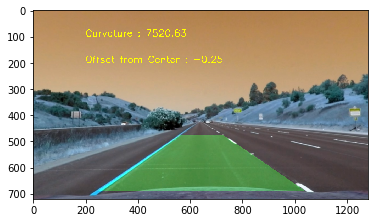

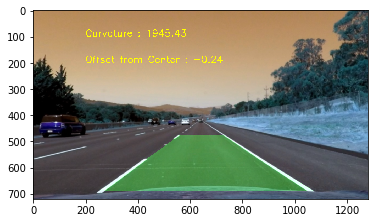

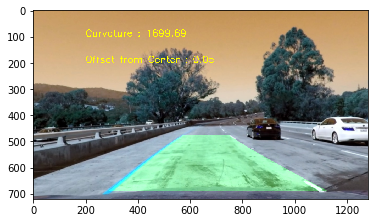

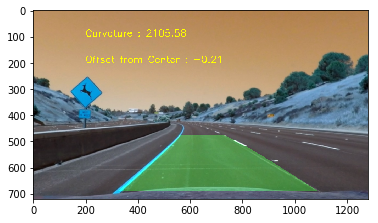

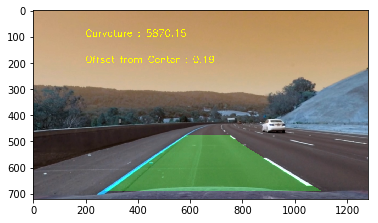

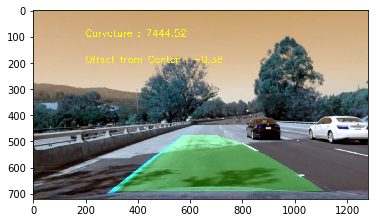

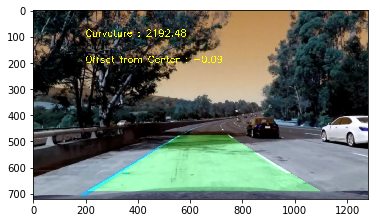

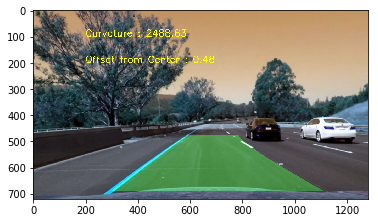

In [10]:
import glob
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    plt.imshow(process_each_image(cv2.imread(fname)))
    plt.show() 

In [11]:
output = "project_video_with_laned_annotated_Run3.mp4"
clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(process_each_image)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_with_laned_annotated_Run3.mp4
[MoviePy] Writing video project_video_with_laned_annotated_Run3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:49<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_laned_annotated_Run3.mp4 

